In [1]:
import gpytorch
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from types import SimpleNamespace as Namespace
from scipy.stats import multivariate_normal

In [2]:
import utils

In [3]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Dummy generative model

In [13]:
def f(x, add_noise=True):
    
    y = torch.sin(x * (2 * np.pi))
    if add_noise:
        y += torch.randn(x.size()) * np.sqrt(0.04)
        
    return y

# Bayesian opt

In [5]:
# We will use the simplest form of GP model, exact inference
class GP(gpytorch.models.ExactGP):
    def __init__(self):
        super(GP, self).__init__(
            torch.empty(0), 
            torch.empty(0), 
            gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
            
    def predict(self, test_x):
        
        # Get into evaluation (predictive posterior) mode
        self.eval()

        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            output = self(test_x)
            observed_pred = self.likelihood(output)
        return observed_pred
    
    @property
    def gp_param(self):
        return torch.cat([param.data.flatten() for param in self.parameters()])
        
    def fit(self, train_x, train_y, learning_rate=0.1, n_epochs=25):
    
        self.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        # Find optimal model hyperparameters
        self.train()

        # Use the adam optimizer
        # Includes GaussianLikelihood parameters
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        
        previous_gp_param = self.gp_param.clone()

        for i in range(n_epochs):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = self(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()

            optimizer.step()
            
            if torch.allclose(self.gp_param, previous_gp_param, rtol=1e-05, atol=1e-04):
                print(f"Early stop at iter {i}")
                break
            previous_gp_param = self.gp_param.clone()

Early stop at iter 229


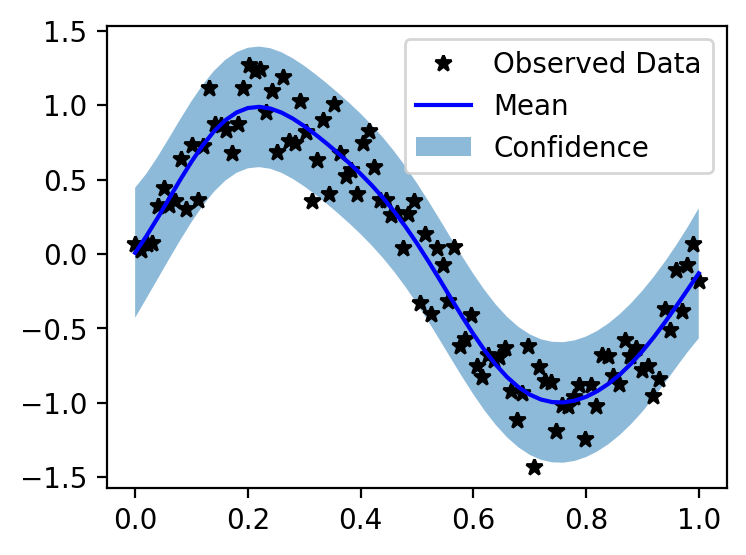

In [8]:
gp = GP()
gp.fit(train_x, train_y, n_epochs=1000)
pred = gp.predict(test_x)
utils.plot.gp_plot(pred, train_x=train_x, train_y=train_y, test_x=test_x);

In [10]:
class BayesOpt:
    
    def __init__(self):
        self.gp = GP()

    def x_new(self, n_warmup=1000):
        
        def objective(x):
            pred = self.gp.predict(torch.from_numpy(x).float())
            ucb = self.ucb(pred)
            return - ucb.numpy()
        
        x_warmup = np.random.random(n_warmup)
        y_warmup = - objective(x_warmup)
        bounds = [[0., 1.]]
        best_x = x_warmup[np.argmax(y_warmup)]
        res = minimize(objective,
               x0=best_x,
               bounds=bounds,
               method="L-BFGS-B")
        x_max = torch.from_numpy(res.x).float()
        return x_max
    
    def argmax_m(self, n_warmup=1000):
        
        def objective(x):
            pred = self.gp.predict(torch.from_numpy(x).float())
            return - pred.mean
        
        x_warmup = np.random.random(n_warmup)
        y_warmup = - objective(x_warmup)
        bounds = [[0., 1.]]
        best_x = x_warmup[np.argmax(y_warmup)]
        res = minimize(objective,
               x0=best_x,
               bounds=bounds,
               method="L-BFGS-B")
        x_max = torch.from_numpy(res.x).float()
        return x_max
        
    def ucb(self, pred, gamma=2.576):
        # gamma param value from https://github.com/fmfn/BayesianOptimization
        # a(x;λ)=μ(x)+λσ(x)
        return pred.mean + gamma*pred.stddev
    
    def run(self, f, n_warm_up=5, n_epochs=25):
        warmup_x = torch.rand(n_warm_up)
        warmup_y = f(warmup_x)
        train_x = warmup_x.clone()
        train_y = warmup_y.clone()
        for _ in range(n_epochs):
            self.gp.fit(train_x, train_y)
            x_new = self.x_new()
            y_new = f(x_new)
            train_x = torch.cat((train_x, x_new), 0)
            train_y = torch.cat((train_y, y_new), 0)
            
            if torch.allclose(train_x[-1], train_x[-2]):
                print(f"Converged at iter {_}")
                break
                        
        x_max = self.argmax_m()
        train_x, train_y = train_x[n_warm_up:], train_y[n_warm_up:]
        return Namespace(
            train_x=train_x, train_y=train_y, 
            warmup_x=warmup_x, warmup_y=warmup_y,
            x_max=x_max)
        
bo = BayesOpt()
bo_res = bo.run(f)

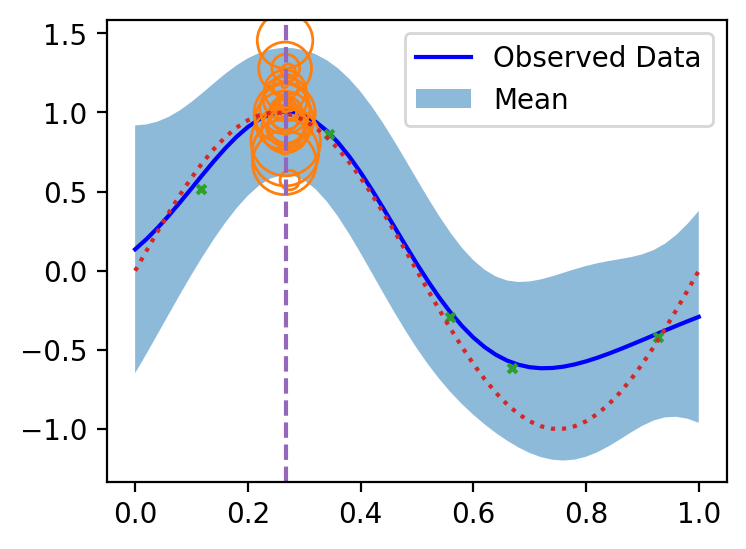

In [14]:
test_x = torch.linspace(0, 1, 51)

pred = bo.gp.predict(test_x)
ax = utils.plot.gp_plot(pred, train_x=None, train_y=None, test_x=test_x)
# Plot warming up as crosses
ax.scatter(bo_res.warmup_x.numpy(), 
           bo_res.warmup_y.numpy(), 
           marker="x", 
           c='C2', 
           zorder=2, 
           s=10)
# Plot training data as dots
ax.scatter(bo_res.train_x.numpy(), 
           bo_res.train_y.numpy(), 
           facecolors='none', 
           color='C1', 
           zorder=2, 
           s=(1+ np.arange(len(bo_res.train_x)))**2)

ax.plot(test_x, f(test_x, add_noise=False), color='C3', linestyle=":")
ax.axvline(x=bo_res.x_max.item(), color='C4', linestyle="--");